# Mask ocean from tiles

In [1]:
# import geopandas as gpd
# import pandas as pd
# import pathlib
# import pystac

import numpy as np
import rasterio
from rasterio.features import shapes, geometry_mask
import rioxarray
import json
import os


In [2]:
import os
os.getcwd()

'/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/notebooks/preprocessing'

### Get tile and normalise

In [3]:
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
catalog_path = os.path.join(homedir,'Data/tiles')

dataPath = os.path.join(homedir,'Data/tiles/training_tiles')
imName = 'S2_composite_2019-11-1_2020-3-1_tile_50.tif'

data = rioxarray.open_rasterio(os.path.join(dataPath,imName) ).isel(band=[0,1,2])
data.rio.bounds()

print(data.min().values, data.max().values)



1 19712


In [4]:
data.shape
# data.transpose('y','x','band').plot.imshow(vmin=0,vmax=10000)  # samples, x_win, y_win, bands

(3, 12503, 12505)

## Get ocean mask and apply

<AxesSubplot:>

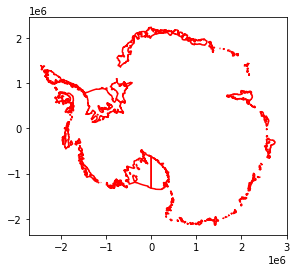

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

iceshelf_poly_path = os.path.join(homedir,'Data/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp')
iceshelf_poly = gpd.read_file(iceshelf_poly_path).to_crs(epsg=3031)
# print(iceshelf_poly)
# iceshelf_poly.plot()

fig,ax=plt.subplots(1)
iceshelf_poly.to_crs(epsg=3031).boundary.plot(ax=ax,color='red')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


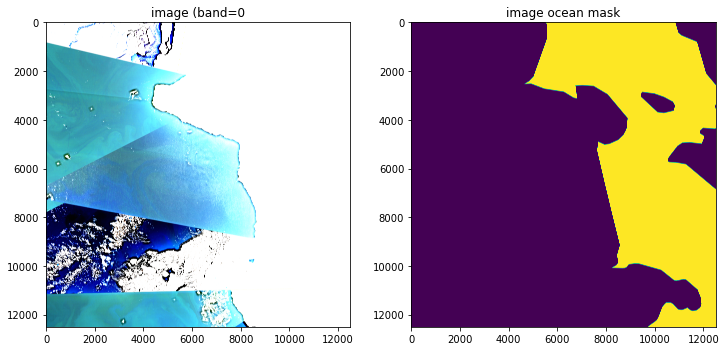

In [67]:
gdf = iceshelf_poly
mask = data.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
mask = mask.rio.clip(gdf.geometry, gdf.crs, drop=False, invert=False) # mask 

fig,axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].imshow(data.isel(band=0)) 
axs[0].imshow(data.transpose('y','x','band'), vmin=0.4, vmax=1)
axs[1].imshow(mask.isel(band=0))
axs[0].set_title('image (band=0');
axs[1].set_title('image ocean mask');

## Demo: cut into windows, drop ocean windows, and stitch back together

In [40]:
def _generate_cutouts(da,xwin=100,ywin=100,stride=100):
    
    # generate windows
    da = da.rolling(x=xwin, y=ywin)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=stride)

    # drop NaN-containing windows: here lies the issue with eventual reconstruction
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any') # (band, x_win, y_win, sample)

    return da.transpose('sample','y_win','x_win','band')

def encode_to_fake_lspace(windows):
    lspace = windows.mean(dim=['y_win','x_win'])
    return lspace

def unstack_data(encoded_data):
    output = encoded_data.unstack()  # x, y, bands 
    
    return output


### Example: without ocean mask

In [63]:
cutouts_data = _generate_cutouts(data)
print('cutouts shape ', cutouts_data.dims, cutouts_data.shape ) # n_samples, xwin, ywin, 3


encoded_da = encode_to_fake_lspace( cutouts_data    )
print('encoded data shape ' , encoded_da.dims, encoded_da.shape ) # samples, bands

decoded_da = unstack_data(encoded_da).transpose('band','y','x') # band, y , x
print('decoded data shape ' , decoded_da.dims, decoded_da.shape) # bands, x,y

# decoded_da.isel(band=0).plot.imshow()

cutouts shape  ('sample', 'y_win', 'x_win', 'band') (15625, 100, 100, 3)
encoded data shape  ('sample', 'band') (15625, 3)
decoded data shape  ('band', 'y', 'x') (3, 125, 125)


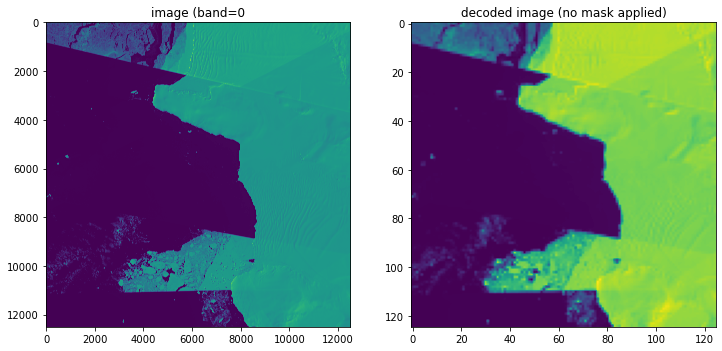

In [70]:
## With masking ocean pixels

data_masked = data.where(mask==1) # fill ocean pixels with NaN

cutouts_masked = _generate_cutouts(data_masked)
print('cutouts shape ', cutouts_masked.dims, cutouts_masked.shape ) # n_samples, xwin, ywin, 3

encoded_masked = encode_to_fake_lspace( cutouts_masked    )
print('encoded data shape ' , encoded_masked.dims, encoded_masked.shape ) # samples, bands

decoded_masked = unstack_data(encoded_masked).transpose('band','y','x') # band, y , x
print('decoded data shape ' , decoded_masked.dims, decoded_masked.shape) # bands, x,y


cutouts shape  ('sample', 'y_win', 'x_win', 'band') (4720, 100, 100, 3)
encoded data shape  ('sample', 'band') (4720, 3)
decoded data shape  ('band', 'y', 'x') (3, 125, 76)


encoded data shape  ('sample', 'band') (4720, 3)
decoded data shape  ('band', 'y', 'x') (3, 125, 76)


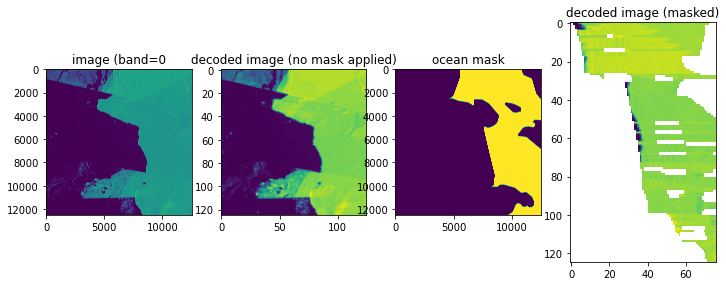

In [75]:
fig,axs = plt.subplots(1,4,figsize=(12,6))
axs[0].imshow(data.isel(band=0)) #.transpose('y','x','band'))
axs[1].imshow(decoded_da.isel(band=0))
axs[2].imshow(mask.isel(band=0))
axs[3].imshow(decoded_masked.isel(band=0))
axs[0].set_title('image (band=0');
axs[1].set_title('decoded image (no mask applied)');
axs[2].set_title('ocean mask');
axs[3].set_title('decoded image (masked)');

# Merge deconstructed shape back to original grid to see if that solves data-gap problem

In [ ]:
import xarray as xr

In [95]:
# xarray combine: doesnt work due to heterogenous grid


# combined = xr.combine_by_coords([decoded_masked, data]) 

In [ ]:
# xarray merge: doesnt work; only NaNs?

decoded_masked.name='decoded_masked'
data.name='img_data'
merged = xr.merge([decoded_masked, data])
merged['decoded_masked']

merged['decoded_masked'].isel(band=0).plot.imshow()

In [87]:
# reproject griddata to original grid

import rasterio as rio

img_to_match_to = data
img = decoded_masked


# -- match grid (extent, resolution and projection)
img_repr_match = img.rio.reproject_match(img_to_match_to,resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308

# advised to update coords
img_repr_match = img_repr_match.assign_coords({
    "x": img_to_match_to.x,
    "y": img_to_match_to.y,
})

img_repr_match
# da_conc = xr.concat([img_to_match_to, img_repr_match],dim='band',join='outer',coords='all',combine_attrs='drop_conflicts')#,fill_value=1)


<xarray.DataArray 'decoded_masked' (band: 3, y: 12503, x: 12505)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 -1.625e+06 -1.625e+06 ... -1.5e+06 -1.5e+06
  * y            (y) float64 -7.5e+05 -7.5e+05 -7.5e+05 ... -8.75e+05 -8.75e+05
  * band         (band) int64 1 2 3
    spatial_ref  int64 0
Attributes:
    _FillValue:  nan

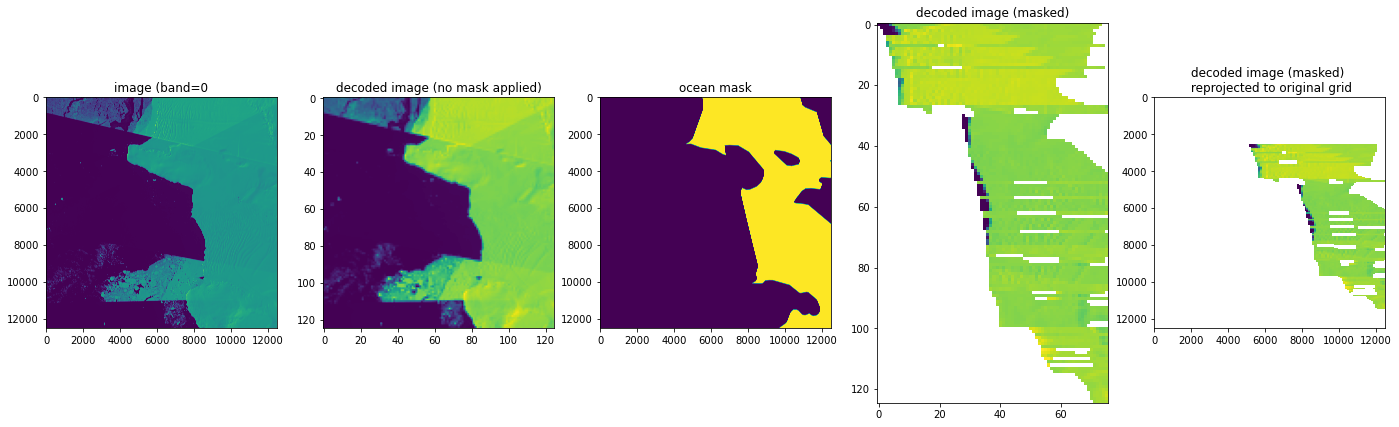

In [94]:
fig,axs = plt.subplots(1,5,figsize=(24,12))
axs[0].imshow(data.isel(band=0)) #.transpose('y','x','band'))
axs[1].imshow(decoded_da.isel(band=0))
axs[2].imshow(mask.isel(band=0))
axs[3].imshow(decoded_masked.isel(band=0))
axs[4].imshow(img_repr_match.isel(band=0))
axs[0].set_title('image (band=0');
axs[1].set_title('decoded image (no mask applied)');
axs[2].set_title('ocean mask');
axs[3].set_title('decoded image (masked)');
axs[4].set_title('decoded image (masked) \n reprojected to original grid');
